In [1]:
import os
import time
os.getcwd()

'/Users/yikaitang/Documents/GitHub/agentarium/examples/state_punishment/notebooks'

In [2]:
%load_ext autoreload

# --------------- #
# region: Imports #
import os
import sys
module_path = os.path.abspath('../../..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
# endregion       #
# --------------- #

from examples.state_punishment.utils import (
    init_log, parse_args, load_config,
    create_models,
    create_agents,
    create_entities,
)
config_path = '../configs/config_fixed_rate_no_vote.yaml'
from examples.state_punishment import agents, entities
from examples.state_punishment.env import state_punishment
from agentarium.logging_utils import GameLogger
from agentarium.models import human_player
from agentarium.utils import visual_field_sprite, image_from_array
from examples.state_punishment.state_sys import state_sys
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random
import argparse

cfg = load_config(argparse.Namespace(config=config_path))

models = create_models(cfg)
agents = create_agents(cfg, models)
entities = create_entities(cfg)
env = state_punishment(cfg, agents, entities)


for ixs, agent in enumerate(agents):
    agent.model = human_player.ModelHumanPlayer(
         action_space=4, 
         state_size = cfg.model.iqn.parameters.state_size, 
         extra_percept_size = cfg.model.iqn.parameters.extra_percept_size,
         memory_size=1, 
         name=f'human {ixs}')
    # agent.model.load(
    #      f'../models/checkpoints/fixed_punishment_rate_0.75_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_agent{ixs}_iRainbowModel_20241127-04111732699956.pkl')
    # agent.model.load(
    #      '../models/checkpoints/fixed_punishment_rate_1.0_oneAs_size15_init_spawn_0.2_agent0_iRainbowModel.pkl'
    # )
    # agent.model.epsilon = 0.01


for epoch in range(1):
    # Reset the environment at the start of each epoch
        env.reset()
        images_anim = []
        # for agent in env.agents:
        #     agent.reset(env)
        random.shuffle(agents)

        scores = GameLogger(max_epochs=1)

        cfg.state_sys.prob_list = {'Gem': cfg.state_sys.prob_list.Gem,
                                   'Coin': cfg.state_sys.prob_list.Coin,
                                   'Bone': cfg.state_sys.prob_list.Bone}
        # initialize state system
        state_entity = state_sys(
            cfg.state_sys.init_prob, 
            cfg.state_sys.prob_list, 
            cfg.state_sys.magnitude, 
            cfg.state_sys.taboo,
            cfg.state_sys.change_per_vote
            )
        print(state_entity.prob_list)
        env.cache['harm'] = [0 for _ in range(len(agents))]

        done = 0 
        turn = 0
        losses = 0
        game_points = [0 for _ in range(len(agents))]

        while not done:

            turn = turn + 1

            entities = env.get_entities_for_transition()
            # Entity transition
            for entity in entities:
                entity.transition(env)

            img = visual_field_sprite(env.world, tile_size = env.tile_size)
            clear_output(wait = True)
            # scores.pretty_print(
            #      'jupyter-mode',
            #      epoch = epoch,
            #      turn = turn,
            #      reward = game_points,
            # )
            
            img = image_from_array(img)
            time.sleep(0.1)
            plt.imshow(img)
            plt.show()
            images_anim.append(img)
            print(state_entity.prob)
            print(game_points)


            # Agent transition
            for agent in agents:

                (state,
                action,
                reward,
                next_state,
                done_
                ) = agent.transition(env, state_entity)

                img = visual_field_sprite(env.world, tile_size = env.tile_size)
                img = image_from_array(img)
                # print(agent.model.name)
                # plt.imshow(img)
                plt.show()
                # if agent.ixs == 0:
                #      images_anim.append(img)

                if turn >= cfg.experiment.max_turns or done_:
                    done = 1

                exp = (1, (state, action, reward, next_state, done))
                # agent.episode_memory.append(exp)

                game_points[agent.ixs] += reward

KeyboardInterrupt: 

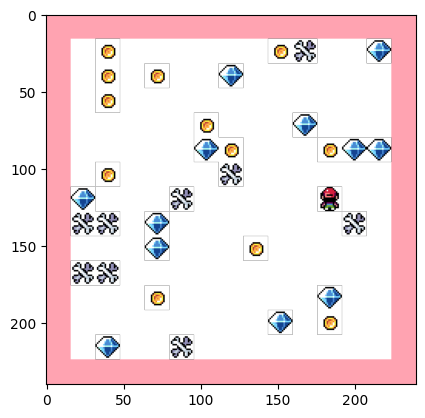

this gem    type  location over being_checked timepoint check_index
3   gem   (1, 13)    0          True         0           0
6   gem    (2, 7)    0          True         0           0
9   gem   (4, 10)    0          True         0           0
10  gem    (5, 6)    0          True         0           0
13  gem   (5, 12)    0          True         0           0
14  gem   (5, 13)    0          True         0           0
17  gem    (7, 1)    0          True         0           0
19  gem   (7, 11)    0          True         0           0
22  gem    (8, 4)    0          True         0           0
24  gem    (9, 4)    0          True         0           0
29  gem  (11, 11)    0          True         0           0
30  gem   (12, 9)    0          True         0           0
32  gem   (13, 2)    0          True         0           0     type  location over being_checked timepoint check_index
0   coin    (1, 2)    0          True         0           0
1   coin    (1, 9)    0          True        

NameError: name 'll' is not defined

In [5]:
%load_ext autoreload

# --------------- #
# region: Imports #
import os
import sys
module_path = os.path.abspath('../../..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
# endregion       #
# --------------- #

from examples.state_punishment.utils import (
    init_log, parse_args, load_config,
    create_models,
    create_agents,
    create_entities,
)
config_path = '../configs/config_fixed_rate_no_vote.yaml'
from examples.state_punishment import agents, entities
from examples.state_punishment.env import state_punishment
from examples.state_punishment.utils import inspect_the_env
from agentarium.logging_utils import GameLogger
from agentarium.models import human_player
from agentarium.utils import visual_field_sprite, image_from_array
from examples.state_punishment.state_sys import state_sys, monitor
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random
import argparse

cfg = load_config(argparse.Namespace(config=config_path))

models = create_models(cfg)
agents = create_agents(cfg, models)
entities = create_entities(cfg)
env = state_punishment(cfg, agents, entities)


for ixs, agent in enumerate(agents):
    agent.model = human_player.ModelHumanPlayer(
         action_space=4, 
         state_size = cfg.model.iqn.parameters.state_size, 
         extra_percept_size = cfg.model.iqn.parameters.extra_percept_size,
         memory_size=1, 
         name=f'human {ixs}')
    # agent.model.load(
    #      f'../models/checkpoints/fixed_punishment_rate_0.75_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_agent{ixs}_iRainbowModel_20241127-04111732699956.pkl')
    # agent.model.load(
    #      '../models/checkpoints/fixed_punishment_rate_1.0_oneAs_size15_init_spawn_0.2_agent0_iRainbowModel.pkl'
    # )
    # agent.model.epsilon = 0.01


for epoch in range(1):
    # Reset the environment at the start of each epoch
        env.reset()
        images_anim = []
        # for agent in env.agents:
        #     agent.reset(env)
        random.shuffle(agents)

        scores = GameLogger(max_epochs=1)

        cfg.state_sys.prob_list = {'Gem': cfg.state_sys.prob_list.Gem,
                                   'Coin': cfg.state_sys.prob_list.Coin,
                                   'Bone': cfg.state_sys.prob_list.Bone}
        # initialize state system
        state_entity = state_sys(
            cfg.state_sys.init_prob, 
            cfg.state_sys.prob_list, 
            cfg.state_sys.magnitude, 
            cfg.state_sys.taboo,
            cfg.state_sys.change_per_vote
            )
        print(state_entity.prob_list)
        
        monitor = monitor(2, ['gem'], 15) # initiate monitor
        
        env.cache['harm'] = [0 for _ in range(len(agents))]

        done = 0 
        turn = 0
        losses = 0
        game_points = [0 for _ in range(len(agents))]

        while not done:

            turn = turn + 1

            entities = env.get_entities_for_transition()
            # Entity transition
            for entity in entities:
                entity.transition(env)

            img = visual_field_sprite(env.world, tile_size = env.tile_size)
            clear_output(wait = True)
            # scores.pretty_print(
            #      'jupyter-mode',
            #      epoch = epoch,
            #      turn = turn,
            #      reward = game_points,
            # )
            
            img = image_from_array(img)
            time.sleep(0.1)
            plt.imshow(img)
            plt.show()
            images_anim.append(img)
            print(state_entity.prob)
            print(game_points)

            # update the record of the monitor
            new_data = monitor.collect_new_state_info(env, types=None, turn=monitor.time, done=done)
            monitor.update(new_data)
            
   
            # Agent transition
            for agent in agents:

                (state,
                action,
                reward,
                next_state,
                done_
                ) = agent.transition(env, state_entity)

                img = visual_field_sprite(env.world, tile_size = env.tile_size)
                img = image_from_array(img)
                # print(agent.model.name)
                # plt.imshow(img)
                plt.show()
                # if agent.ixs == 0:
                #      images_anim.append(img)

                if turn >= cfg.experiment.max_turns or done_:
                    done = 1

                exp = (1, (state, action, reward, next_state, done))
                # agent.episode_memory.append(exp)

                game_points[agent.ixs] += reward

            img = visual_field_sprite(env.world, tile_size = env.tile_size)
            clear_output(wait = True)
            img = image_from_array(img)
            time.sleep(0.1)
            plt.imshow(img)
            plt.show()

            # regular check all resources being monitored
            monitor.regular_check_all_resources(turn, state_entity, agents)
            monitor.time_of_next_check()

issue: the new state info does not update correctly --> the gem did not disappear

In [4]:
monitor.time, monitor.check_time, monitor.check_index

(13, 14, 6)

In [3]:
monitor.resource_to_monitor

'gem'

In [7]:
monitor.record['check_index'].unique()

array([0, nan, 1, 2, 3, 4, 5], dtype=object)

In [3]:
agent.to_be_punished, monitor.resource_to_monitor

({'gem': 0, 'bone': 0, 'coin': 0}, ['gem'])

In [4]:
monitor.record[monitor.record.timepoint==9]

,type,location,over,being_checked,timepoint,check_index
294,bone,"(2, 3)",0,True,9,4
295,gem,"(2, 6)",0,True,9,4
296,coin,"(2, 9)",0,True,9,4
297,gem,"(3, 3)",0,True,9,4
298,bone,"(3, 7)",0,True,9,4
299,bone,"(3, 10)",0,True,9,4
300,bone,"(3, 11)",0,True,9,4
301,coin,"(3, 12)",0,True,9,4
302,coin,"(4, 2)",0,True,9,4
303,bone,"(4, 8)",0,True,9,4


In [18]:
monitor.record[monitor.record.timepoint==1]

,type,location,over,being_checked,timepoint,check_index
0,gem,"(1, 2)",0,True,1,0
1,coin,"(1, 8)",0,True,1,0
2,coin,"(2, 1)",0,True,1,0
3,coin,"(2, 2)",0,True,1,0
4,coin,"(2, 13)",0,True,1,0
5,bone,"(3, 1)",0,True,1,0
6,coin,"(3, 13)",0,True,1,0
7,coin,"(4, 9)",0,True,1,0
8,bone,"(6, 3)",0,True,1,0
9,bone,"(6, 10)",0,True,1,0


In [13]:
inspect_the_env(env, types=['gem'])

,type,location
21,gem,"(1, 6)"
42,gem,"(2, 12)"
56,gem,"(3, 11)"
70,gem,"(4, 10)"
79,gem,"(5, 4)"
87,gem,"(5, 12)"
99,gem,"(6, 9)"
103,gem,"(6, 13)"
108,gem,"(7, 3)"
109,gem,"(7, 4)"


*****************************************!!!!!!!!!!!!!!!!!!!!!!!!!!
1. determine the taboo before the game starts
2. add initial items into the monitor record (search for taboo types)
3. during checks, a transgression is judged as happening when the item identity of the things on the original location of a taboo shifts. (not based on existing or not)
4. specifically, for last check, filter all taboos, for current check, filter all the locations of the original taboos, compare whether any taboos disappear

In [7]:
monitor.record

,type,location,over,being_checked,is_existing,timepoint,check_index


In [6]:
state_entity.prob_list.Gem

0.0

In [6]:
import pandas as pd

In [13]:
x = {'a':[1,2], 'b':[2,3]}
x = pd.DataFrame(x)
x[x.b.isin([3])]

,a,b
1,2,3


In [7]:
for index, _ in np.ndenumerate(env.world[:, :, 0]):
    H, W = index  # Get the coordinates
    # Return visualization image
    print(type(env.world[H, W, 0]), env.world[H, W, 0].appearance)

<class 'examples.state_punishment.entities.Wall'> [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'examples.state_punishment.entities.Wall'> [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'examples.state_punishment.entities.Wall'> [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'examples.state_punishment.entities.Wall'> [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'examples.state_punishment.entities.Wall'> [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'examples.state_punishment.entities.Wall'> [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'examples.state_punishment.entities.Wall'> [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'examples.state_punishment.entities.Wall'> [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'examples.state_punishment.entities.Wall'> [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'examples.state_punishment.entities.Wal

In [79]:
from PIL import Image
import imageio.v3 as iio
def create_gif_from_arrays(image_arrays, output_path, duration=100, loop=0):
    """
    Create a GIF from a sequence of images in NumPy array format.

    Args:
        image_arrays (list of np.ndarray): Sequence of images as NumPy arrays.
        output_path (str): Path to save the output GIF.
        duration (int): Duration of each frame in milliseconds (controls speed).
        loop (int): Number of times the GIF should loop (0 for infinite).
    """
    # Convert NumPy arrays to PIL Images
    if type(image_arrays[0]) != Image.Image:
        pil_images = [Image.fromarray(img) for img in image_arrays]
    else:
        pil_images = image_arrays
    
    # Save as GIF
    pil_images[0].save(
        output_path,
        save_all=True,
        append_images=pil_images[1:],
        duration=duration,
        loop=loop
    )
    print(f"GIF saved at {output_path}")


def create_gif_iio(images, output_path, fps=10):
    """
    Create a GIF from a list of image arrays using `imageio`.

    Args:
        images (list of numpy.ndarray): A list of image arrays (e.g., RGB or grayscale).
        output_path (str): Path to save the generated GIF.
        fps (int): Frames per second, controlling the speed of the GIF.
    """
    # Calculate the duration per frame in seconds
    duration_per_frame = 1 / fps
    
    # Save the GIF
    iio.imwrite(output_path, images, format="GIF", duration=duration_per_frame)
    print(f"GIF saved at {output_path}")


from PIL import Image, ImageDraw

from PIL import Image

def create_gif_from_pil_force_clean(image_list, output_path, duration=100, loop=0, background_color=(0, 0, 0)):
    """
    Create a GIF from a list of `PIL.Image.Image` objects, ensuring no shadow artifacts.
    Ensures each frame has a fresh background.

    Args:
        image_list (list of PIL.Image.Image): Sequence of PIL images.
        output_path (str): Path to save the output GIF.
        duration (int): Duration of each frame in milliseconds (controls speed).
        loop (int): Number of times the GIF should loop (0 for infinite).
        background_color (tuple): RGB color to reset the background for each frame.
    """
    # Determine the size of the images
    width, height = image_list[0].size

    # Ensure all frames are re-rendered on a clean background
    cleaned_frames = []
    for img in image_list:
        # Create a blank canvas for each frame
        blank_frame = Image.new(mode=img.mode, size=(width, height), color=background_color)
        
        # Convert the image to RGBA to handle transparency (if needed)
        if img.mode != "RGBA":
            img = img.convert("RGBA")
        
        # Paste the current frame onto the blank canvas
        blank_frame.paste(img, (0, 0), mask=img if img.mode == "RGBA" else None)
        cleaned_frames.append(blank_frame)

    # Save as GIF
    cleaned_frames[0].save(
        output_path,
        save_all=True,
        append_images=cleaned_frames[1:],
        duration=duration,
        loop=loop
    )
    print(f"GIF saved at {output_path}")


In [80]:
# from examples.state_punishment.utils import create_gif_from_arrays
print(type(images_anim[0]) == Image.Image)
create_gif_from_pil_force_clean(images_anim, 'movie_punishment_0.75_gem_has_value_diff_models.gif', 200)


True
GIF saved at movie_punishment_0.75_gem_has_value_diff_models.gif
